In [1]:
import sys
sys.path.append('/scratch/gf332/Misc/BVAE/code')

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from tqdm import tqdm

from bnn import DummyBNN
from adaptive_sghmc import AdaptiveSGHMC
from sghmc import SGHMC

%matplotlib inline

tfd = tfp.distributions
tfl = tf.keras.layers

paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)

#plt.rc("text", usetex=True)
plt.rc("font", size=32.0, family="serif")
plt.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
def f(x):
    return np.sinc(x * 10. - 5.)

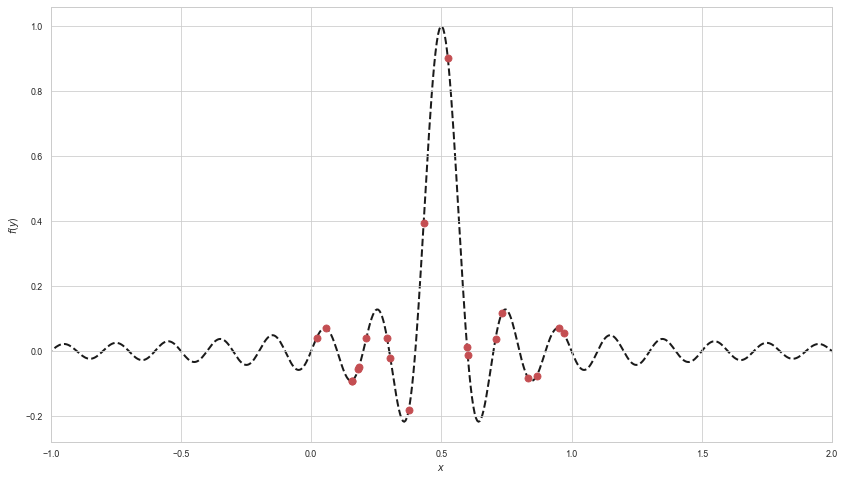

In [4]:
rng = np.random.RandomState(42)

num_points = 20

x = rng.rand(num_points).astype(np.float32)
y = f(x)

grid = np.linspace(-2., 3., 1000).astype(np.float32)
fvals = f(grid)

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(grid, fvals, linestyle='--', c='k', zorder=0)
ax.scatter(x, y, marker='o', c='r', zorder=1, s=50)

ax.set_xlim([-1., 2.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

plt.show()

In [5]:
bnn = DummyBNN()
bnn.build(input_shape=(None, 1))

In [6]:
@tf.function
def train_step(model, batch, labels):

    with tf.GradientTape() as tape:
        
        data_size = tf.cast(num_points, tf.float32)
        
        pred = model(batch)
        
        likelihood = tfd.Normal(loc=pred, scale=tf.exp(0.5 * model.likelihood_log_var))
        log_likelihood = tf.reduce_mean(likelihood.log_prob(labels))
        
        var_prior_log_prob = model.var_prior.log_prob(tf.exp(model.likelihood_log_var)) / data_size
        
        weight_prior_log_prob = model.weight_prior_log_prob() / data_size
        
        loss = -(log_likelihood + weight_prior_log_prob + var_prior_log_prob)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return pred, log_likelihood, var_prior_log_prob, weight_prior_log_prob

In [7]:
batch_size = num_points
iterations = 20000
keep_every = 50
burnin = 2000
learning_rate = 1e-2
momentum_decay = 0.05

log_every = 2000

x_mean, x_var = tf.nn.moments(tf.convert_to_tensor(x), axes=[0])
x_std = tf.sqrt(x_var)
y_mean, y_var = tf.nn.moments(tf.convert_to_tensor(y), axes=[0])
y_std = tf.sqrt(y_var)

x_normalized = (x - x_mean) / x_std
y_normalized = (y - y_mean) / y_std

ds = tf.data.Dataset.from_tensor_slices((x_normalized[:, None], y_normalized[:, None]))
ds = ds.shuffle(500).repeat().batch(batch_size).prefetch(16)

optimizer = {
    "adaptive_sghmc": AdaptiveSGHMC(learning_rate=learning_rate,
                                    burnin=burnin,
                                    data_size=num_points,
                                    overestimation_rate=3.,
                                    initialization_rounds=10,
                                    momentum_decay=momentum_decay),
    
    "sghmc": SGHMC(learning_rate=1e-6,
                   data_size=num_points,
                   momentum_decay=momentum_decay),
    
    "adam": tf.optimizers.Adam(learning_rate=1e-3),
}["adaptive_sghmc"]

In [8]:
weight_samples = []

i = 0

for batch, labels in tqdm(ds.take(iterations), total=iterations):

    i = i + 1
    
    # Resample scale hyperparameters every epoch

    pred, ll, vplp, wplp = train_step(bnn,
                                      batch, 
                                      labels)
    
    if i >= burnin and i % keep_every == 0:
        weight_samples.append(bnn.get_weights())
        
    if i % log_every == 0:
        mse = tf.reduce_mean(tf.math.squared_difference(pred, labels[:, None]))
        
        print(f"iteration {i}: "
              f"MSE: {mse}, "
              f"LL: {ll}, "
              f"weight prior LL: {wplp}, "
              f"var prior LL: {vplp}")

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 1/20000 [00:02<16:12:03,  2.92s/it]

SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!


 11%|█         | 2117/20000 [00:06<00:31, 573.67it/s]

iteration 2000: MSE: 1.9925302267074585, LL: -6.4805192947387695, weight prior LL: -2.482595920562744, var prior LL: -4.6093363761901855


 21%|██        | 4118/20000 [00:10<00:26, 596.95it/s]

iteration 4000: MSE: 1.9976712465286255, LL: 3.088219165802002, weight prior LL: -4.026307582855225, var prior LL: 0.5278435945510864


 31%|███       | 6113/20000 [00:13<00:23, 600.76it/s]

iteration 6000: MSE: 2.000537633895874, LL: 1.5729377269744873, weight prior LL: -5.7126336097717285, var prior LL: 0.46909457445144653


 41%|████      | 8103/20000 [00:16<00:19, 605.04it/s]

iteration 8000: MSE: 1.9943749904632568, LL: 3.094316005706787, weight prior LL: -5.975580215454102, var prior LL: 0.5292918086051941


 50%|█████     | 10070/20000 [00:20<00:16, 603.46it/s]

iteration 10000: MSE: 1.985310673713684, LL: 1.8232940435409546, weight prior LL: -6.135631084442139, var prior LL: 0.4630117416381836


 61%|██████    | 12107/20000 [00:23<00:12, 608.91it/s]

iteration 12000: MSE: 2.003415584564209, LL: -3.6399052143096924, weight prior LL: -5.749154567718506, var prior LL: 0.4477708041667938


 70%|███████   | 14070/20000 [00:26<00:09, 598.70it/s]

iteration 14000: MSE: 2.0004982948303223, LL: 2.9678854942321777, weight prior LL: -5.811628341674805, var prior LL: 0.46003690361976624


 80%|████████  | 16074/20000 [00:30<00:06, 602.23it/s]

iteration 16000: MSE: 1.998052716255188, LL: 3.4454052448272705, weight prior LL: -6.078408718109131, var prior LL: 0.5190503597259521


 90%|█████████ | 18093/20000 [00:33<00:03, 591.60it/s]

iteration 18000: MSE: 1.9938942193984985, LL: 3.3568241596221924, weight prior LL: -6.293004512786865, var prior LL: 0.42196589708328247


100%|██████████| 20000/20000 [00:36<00:00, 545.70it/s]

iteration 20000: MSE: 1.9956246614456177, LL: 3.3550548553466797, weight prior LL: -6.06587028503418, var prior LL: 0.5152451395988464


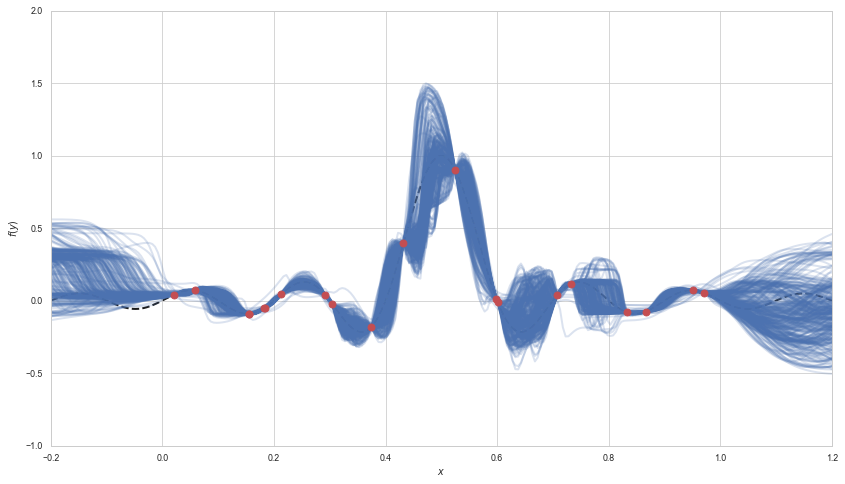

In [14]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 8))

all_preds = []

for weights in weight_samples[:]:
    
    bnn.set_weights(weights)
    
    pred = bnn((grid[:, None] - x_mean) / x_std).numpy()[:, 0]
    pred = y_std * pred + y_mean
    
    ax.plot(grid, pred, c='b', alpha=0.2, zorder=1)
    
    all_preds.append(pred)

all_preds = tf.stack(all_preds, axis=0)

ax.plot(grid, fvals, linestyle='--', c='k', zorder=0)
ax.scatter(x, y, marker='o', c='r', zorder=2, s=50)

ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-1., 2.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

plt.savefig("samples.png")

plt.show()

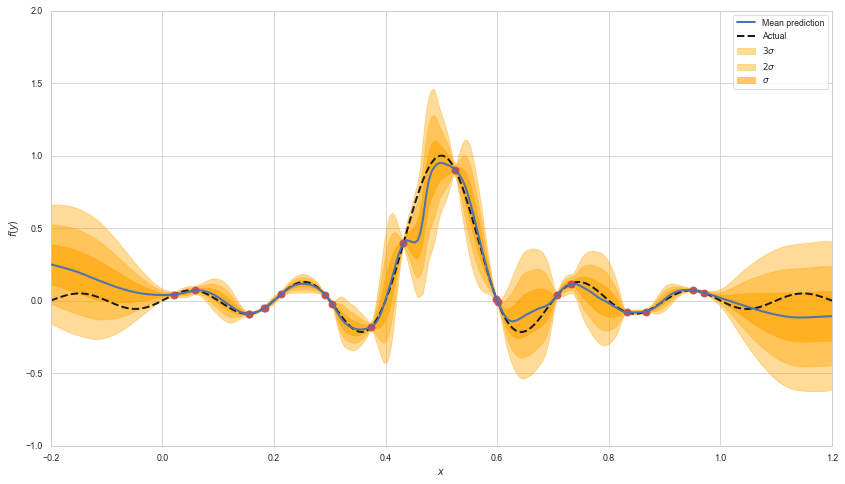

In [15]:
mean_pred, var_pred = tf.nn.moments(all_preds[30:, :], axes=[0])

fig, ax = plt.subplots(figsize=(14, 8))

std_pred = tf.sqrt(var_pred)

ax.plot(grid, mean_pred, linestyle='-', c='b', zorder=4, label="Mean prediction")
ax.fill_between(grid, 
                mean_pred + 3. * std_pred, 
                mean_pred - 3. * std_pred, 
                alpha=0.4, label="$3\sigma$", color='orange')

ax.fill_between(grid, 
                mean_pred + 2. * std_pred, 
                mean_pred - 2. * std_pred, 
                alpha=0.4, label="$2\sigma$", color='orange')

ax.fill_between(grid, 
                mean_pred + std_pred, 
                mean_pred - std_pred, 
                alpha=0.6, label="$\sigma$", color='orange')

ax.plot(grid, fvals, linestyle='--', c='k', zorder=2, label="Actual")
ax.scatter(x, y, marker='o', c='r', zorder=3, s=50)

ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-1., 2.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

ax.legend()

plt.savefig("statistics.png")

plt.show()

In [11]:
bnn.likelihood_log_var

<tf.Variable 'likelihood_log_variance:0' shape=() dtype=float32, numpy=-9.299858>